In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import time
from IPython.display import Image
import random
import IPython.display as display

In [2]:
from services.vse_preprocessor import filter_long_texts, filter_existing_cards
from models.inception import VectorGenerator
from models.vse_model import VSE_Model
from services.evaluator import evaluate

## Dataset

### Preprocess Images


In [3]:
image_folder = '../data/processed_images'

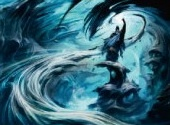

In [4]:
Image(os.path.join(image_folder, random.choice(os.listdir(image_folder))))

En este caso, puesto que la primera codificación basada en redes convolucionales esta entrenada y sus pesos no se van a modificar vamos a dejar calculada esta parte para no hacerlo en cada train step.

Para ello, vamos a cargar el modelo InceptionV3

![alt text](../demo_images/inception.png "Inception")

In [5]:
vector_paths = '../data/image_vectors'

In [6]:
inception_enc = VectorGenerator(vector_paths)

In [7]:
image_dataset = tf.data.Dataset.from_tensor_slices([os.path.join(image_folder, image) for image in os.listdir(image_folder)[:300]])

In [8]:
image_dataset

<TensorSliceDataset shapes: (), types: tf.string>

In [9]:
image_dataset = image_dataset.map(inception_enc.load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

In [10]:
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [11]:
vector_paths = inception_enc.reshape(image_dataset)

In [12]:
np.load(vector_paths[0] + '.npy').shape

(64, 2048)

Una vez realizado este proceso, tendremos los vectores de cada imagen calculados por InceptionV3 guardados para poder utilizarlos en los siguientes pasos.

### Preprocess text

Para el texto vamos a tener en cuenta una serie de consideraciones que veremos a continuación:

In [13]:
df = pd.read_csv('../data/preprocess-dataset-en.csv', sep=';')
df.dropna(inplace=True, subset=['tokenized_text'])

In [14]:
df.head()

,id,multiverseid,name,color,flavor,text,image,set,type,power,toughness,rarity,cmc,mana_cost,layout,tokenized_text,preprocess_text,preprocess_flavor
0,1669af17-d287-5094-b005-4b143441442f,130483.0,Abundance,Green,NaN,"If you would draw a card, you may instead choo...",http://gatherer.wizards.com/Handlers/Image.ash...,10E,Enchantment,NaN,NaN,Rare,4.0,{2}{G}{G},normal,"If you would draw a card, you may instead choo...",would draw card may instead choose land nonlan...,NaN
1,047d5499-a21c-5f5c-9679-1599fcaf9815,132072.0,Academy Researchers,Blue,They brandish their latest theories as warrior...,When Academy Researchers enters the battlefiel...,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Creature — Human Wizard,2,2,Uncommon,3.0,{1}{U}{U},normal,"When <CARDNAME> enters the battlefield, you ma...",cardname enters battlefield may put aura card ...,brandish latest theories warriors would wield ...
2,ee19938c-4007-58f1-8904-fae28007b422,129458.0,Adarkar Wastes,NaN,NaN,{T}: Add {C}. {T}: Add {W} or {U}. Adarkar Was...,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Land,NaN,NaN,Rare,0.0,NaN,normal,<COST>: Add <MANA>. <COST>: Add <MANA> or <MAN...,cost add mana cost add mana mana cardname deal...,NaN
3,8774e18f-3752-5c06-af94-5da3960da9ed,135206.0,Afflict,Black,"One rarely notices a heartbeat, save when it i...",Target creature gets -1/-1 until end of turn. ...,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Instant,NaN,NaN,Common,3.0,{2}{B},normal,Target creature gets <DOWNTURN> until end of t...,target creature gets downturn end turn draw card,one rarely notices heartbeat save stolen
4,4e875bca-0c52-5d60-889d-1db67e261737,130525.0,Aggressive Urge,Green,"The power of the wild, concentrated in a singl...",Target creature gets +1/+1 until end of turn. ...,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Instant,NaN,NaN,Common,2.0,{1}{G},normal,Target creature gets <UPTURN> until end of tur...,target creature gets upturn end turn draw card,power wild concentrated single charge


- Mantener signos de puntuación
- Mantener palabras y conjugaciones (no lemmatización ni stemming)
- Reemplazar nombre de carta por el token < cardname >
- Reemplazar contadores, manás y costes por tokens.

In [15]:
len(df)

50374

In [16]:
df['tokenized_text'].head()

0    If you would draw a card, you may instead choo...
1    When <CARDNAME> enters the battlefield, you ma...
2    <COST>: Add <MANA>. <COST>: Add <MANA> or <MAN...
3    Target creature gets <DOWNTURN> until end of t...
4    Target creature gets <UPTURN> until end of tur...
Name: tokenized_text, dtype: object

In [17]:
df = filter_long_texts(df, 10)

In [18]:
len(df)

11052

In [19]:
filtered_captions, filtered_vector_paths = filter_existing_cards(df, '../data/image_vectors')

In [20]:
len(filtered_captions)

233

In [21]:
len(filtered_vector_paths)

233

### Tokenize captions

In [22]:
max_words = 300

In [23]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="<unk>", filters='', lower=True)

In [24]:
ignore_chars = [' ', '<', '>']   
filtered_captions = ['<start> ' + "".join((char if char.isalnum() or
                    char in ignore_chars else f' {char} ') for char in text) + ' <end>' for text in filtered_captions]

In [25]:
tokenizer.fit_on_texts(filtered_captions)

In [26]:
tokenizer.word_index['<pad>'] = 0

In [27]:
tokenizer.index_word[0] = '<pad>'

In [28]:
train_seqs = tokenizer.texts_to_sequences(filtered_captions)

In [29]:
train_seqs[:5]

[[2, 10, 7, 5, 8, 6, 4, 11, 3],
 [2, 10, 7, 5, 8, 6, 4, 11, 3],
 [2, 14, 9, 15, 28, 31, 25, 4, 26, 22, 32, 4, 3],
 [2, 14, 52, 87, 104, 43, 4, 3],
 [2, 17, 14, 74, 4, 3]]

In [30]:
max_length = max(len(t) for t in train_seqs)

In [31]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(
        train_seqs, maxlen=max_length, padding='post')

In [32]:
cap_vector[0]

array([ 2, 10,  7,  5,  8,  6,  4, 11,  3,  0,  0,  0,  0,  0,  0,  0])

In [33]:
tokenizer.word_index['add']

8

### Create dataset

In [34]:
dataset = tf.data.Dataset.from_tensor_slices((filtered_vector_paths, cap_vector))

In [35]:
dataset

<TensorSliceDataset shapes: ((), (16,)), types: (tf.string, tf.int32)>

In [36]:
batch_size = 16
buffer_size = 1000

In [37]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [38]:
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(buffer_size).batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [39]:
dataset

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

### Define VSE Model

In [40]:
vse = VSE_Model(embedding_dim=300,
                units=512, 
                vocab_size= max_words, 
                tokenizer=tokenizer, 
                checkpoint_path='../models/vse')

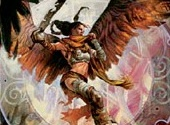

['first', 'strike', '<end>']
Epoch 26 Loss 0.002095
Time taken for 1 epoch 12.696304082870483 sec

Epoch 27 Batch 0 Loss 0.0250


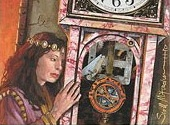

['<cost>', ':', 'add', '<mana>', '.', '<end>']
Epoch 27 Loss 0.002521
Time taken for 1 epoch 14.162118196487427 sec

Epoch 28 Batch 0 Loss 0.0204


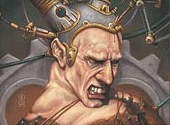

['creatures', 'you', 'control', 'get', '<downturn>', '.', '<end>']
Epoch 28 Loss 0.002004
Time taken for 1 epoch 15.124357461929321 sec

Epoch 29 Batch 0 Loss 0.0288


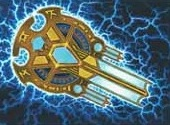

['flash', '<mana>', ',', '<cost>', ':', 'untap', 'target', 'artifact', '.', '<end>']
Epoch 29 Loss 0.001218
Time taken for 1 epoch 14.449540615081787 sec

Epoch 30 Batch 0 Loss 0.0231


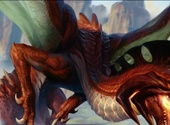

['you', 'control', 'get', '<upturn>', 'and', 'have', 'vigilance', '.', '<end>']
Epoch 30 Loss 0.001488
Time taken for 1 epoch 17.048967599868774 sec



In [41]:
import IPython.display as display
num_steps = len(filtered_vector_paths)
for epoch in range(vse.start_epoch, 30):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = vse.train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    if epoch % 5 == 0:
        print("Saving checkpoint...")
        vse.ckpt_manager.save()
        display.clear_output(wait=True)
    try:
        evaluate_image_path = os.path.join(image_folder, random.choice(os.listdir(image_folder)))
        display.display(Image(evaluate_image_path))
        result = evaluate(vse, evaluate_image_path, '../data/image_vectors')
        print(result)
    except Exception as e:
        print(f"Exception: {str(e)}")

    print('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                      total_loss/num_steps))
    
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
